In [16]:
# Importing Necessary Libraries
# ---
# Here, we import all the libraries required for the lab.

import pandas as pd
import numpy as np
from pathlib import Path

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    classification_report
)
from sklearn.utils.validation import check_is_fitted

# Model saving
import joblib
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)

print("Libraries imported successfully!")


Libraries imported successfully!


In [17]:

# Loading the Dataset
# ---
# We'll load the churn dataset, preprocess the target variable, and separate features (X) from the target (y).

dataset_path = "LabAssig5_stuff/churn.csv"

try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded successfully from '{dataset_path}'.")
except FileNotFoundError:
    print(f"Error: '{dataset_path}' not found. Please ensure the dataset file is in the correct directory.")
    # Creating a dummy dataframe to avoid further errors in the notebook if file is not found
    data = {'State': ['LA', 'IN', 'NY'], 'Account length': [117, 65, 161], 'Area code': [408, 415, 415], 'International plan': ['No', 'No', 'No'], 'Voice mail plan': ['No', 'No', 'No'], 'Number vmail messages': [0, 0, 0], 'Total day minutes': [184.5, 129.1, 332.9], 'Total day calls': [97, 137, 67], 'Total day charge': [31.37, 21.95, 56.59], 'Total eve minutes': [351.6, 228.5, 317.8], 'Total eve calls': [80, 83, 97], 'Total eve charge': [29.89, 19.42, 27.01], 'Total night minutes': [215.8, 208.8, 160.6], 'Total night calls': [90, 111, 128], 'Total night charge': [9.71, 9.4, 7.23], 'Total intl minutes': [8.7, 12.7, 5.4], 'Total intl calls': [4, 6, 9], 'Total intl charge': [2.35, 3.43, 1.46], 'Customer service calls': [1, 4, 4], 'Churn': [False, True, True]}
    df = pd.DataFrame(data)
    print("A dummy dataframe has been created for demonstration purposes.")


# Normalize target variable 'Churn' to binary integer format
df["Churn"] = df["Churn"].astype(str).str.strip()
y = df["Churn"].map({
    "True": 1, "False": 0,
    "1": 1, "0": 0
}).astype(int)

X = df.drop(columns=["Churn"])
print("\nShape:", df.shape)
print("\nFirst 3 rows of the dataset:")
print(X.head(3))




Dataset loaded successfully from 'LabAssig5_stuff/churn.csv'.

Shape: (667, 20)

First 3 rows of the dataset:
  State  Account length  Area code International plan Voice mail plan  \
0    LA             117        408                 No              No   
1    IN              65        415                 No              No   
2    NY             161        415                 No              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                      0              184.5               97   
1                      0              129.1              137   
2                      0              332.9               67   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             31.37              351.6               80             29.89   
1             21.95              228.5               83             19.42   
2             56.59              317.8               97             27.01   

   Total night minutes  Total n

In [18]:

# Feature Identification and Preprocessing Pipeline
# ---
# We identify numeric and categorical columns and create a ColumnTransformer to apply
# StandardScaler to numeric features and OneHotEncoder to categorical features.

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Define transformers
num_transformer = StandardScaler()
# Use a try-except block for scikit-learn version compatibility
try:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Create a robust preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols) if num_cols else ("num", "drop", []),
        ("cat", cat_transformer, cat_cols) if cat_cols else ("cat", "drop", []),
    ],
    remainder='passthrough'
)

print(f"\n# numeric features: {len(num_cols)}, # categorical features: {len(cat_cols)}")
print("Preprocessing pipeline created successfully.")



# numeric features: 16, # categorical features: 3
Preprocessing pipeline created successfully.


In [19]:

# Train-Test Split
# ---
# We split the data into training and testing sets, using stratification to maintain
# the same proportion of target classes in both sets.

# Stratification is only possible if there is more than one class
strata = y if y.nunique() > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=strata
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Target balance (train):", y_train.mean().round(4))
print("Target balance (test):", y_test.mean().round(4))


Train shape: (533, 19)  Test shape: (134, 19)
Target balance (train): 0.1426
Target balance (test): 0.1418


In [20]:

# Model Definition and Training
# ---
# We create pipelines for Bagging and Random Forest classifiers.
# Each pipeline combines the preprocessing steps with the model.
# Then, we fit both models on the training data.

# Define Bagging Classifier Pipeline
bagging_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42, max_depth=10),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ))
])

# Define Random Forest Pipeline
random_forest_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10, # Added max_depth
        n_jobs=-1
    ))
])

# Fit models
print("Training Bagging Classifier...")
bagging_pipe.fit(X_train, y_train)
check_is_fitted(bagging_pipe)
print("Training complete.")

print("\nTraining Random Forest Classifier...")
random_forest_pipe.fit(X_train, y_train)
check_is_fitted(random_forest_pipe)
print("Training complete.")


Training Bagging Classifier...
Training complete.

Training Random Forest Classifier...
Training complete.


In [21]:

# Evaluation Function
# ---
# This function takes a trained model pipeline and evaluates its performance
# on both training and test data, returning a dictionary of key metrics.

def evaluate_model(name, pipe, X_tr, y_tr, X_te, y_te, threshold=0.5):
    """Evaluates a classification model pipeline."""
    # Get probabilities for the positive class
    y_tr_prob = pipe.predict_proba(X_tr)[:, 1]
    y_te_prob = pipe.predict_proba(X_te)[:, 1]

    # Apply threshold to get predictions
    y_tr_pred = (y_tr_prob >= threshold).astype(int)
    y_te_pred = (y_te_prob >= threshold).astype(int)

    # Calculate metrics
    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_te = accuracy_score(y_te, y_te_pred)
    auc_tr = roc_auc_score(y_tr, y_tr_prob) if y_tr.nunique() > 1 else np.nan
    auc_te = roc_auc_score(y_te, y_te_prob) if y_te.nunique() > 1 else np.nan
    cm = confusion_matrix(y_te, y_te_pred, labels=[0, 1])
    clf_rep = classification_report(y_te, y_te_pred, labels=[0, 1], target_names=["No Churn", "Churn"], zero_division=0)

    return {
        "model": name,
        "accuracy_train": acc_tr,
        "accuracy_test": acc_te,
        "roc_auc_train": auc_tr,
        "roc_auc_test": auc_te,
        "confusion_matrix_test": cm,
        "classification_report_test": clf_rep,
    }

print("Evaluation function defined.")


Evaluation function defined.


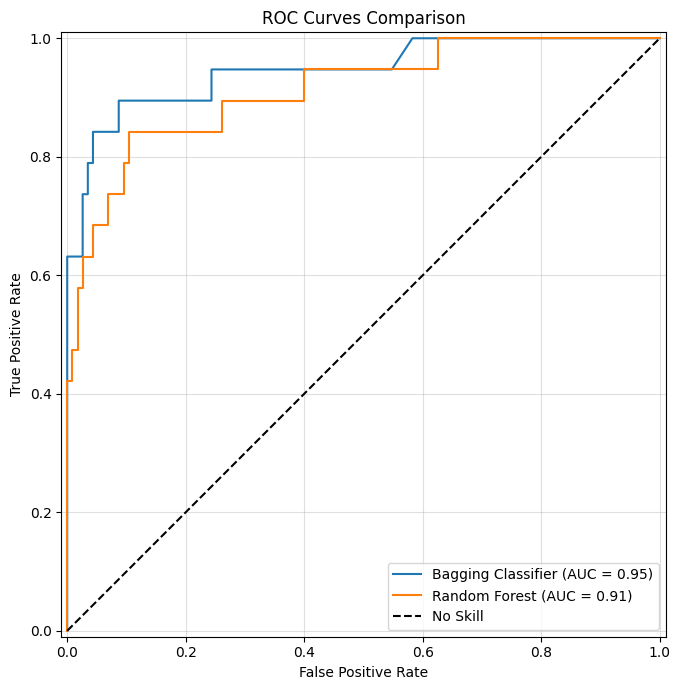

In [22]:
# Plotting ROC Curves
# ---
# We visualize the ROC curves for both models on a single plot to compare
# their performance at different classification thresholds.

plt.figure(figsize=(8, 7))
ax = plt.gca()

try:
    RocCurveDisplay.from_estimator(bagging_pipe, X_test, y_test, name="Bagging Classifier", ax=ax)
    RocCurveDisplay.from_estimator(random_forest_pipe, X_test, y_test, name="Random Forest", ax=ax)
    ax.plot([0, 1], [0, 1], "k--", linewidth=1.5, label="No Skill")
    plt.title("ROC Curves Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ROC plot could not be generated:", e)

In [23]:
# Model Evaluation and Results
# ---
# We evaluate both trained models using our function and display the results
# in a summary table, followed by detailed reports.

results = [
    evaluate_model("Bagging Classifier", bagging_pipe, X_train, y_train, X_test, y_test),
    evaluate_model("Random Forest", random_forest_pipe, X_train, y_train, X_test, y_test),
]

# Create a summary metrics table
metrics_table = pd.DataFrame([{
    "Model": r["model"],
    "Accuracy (Train)": f"{r['accuracy_train']:.4f}",
    "Accuracy (Test)": f"{r['accuracy_test']:.4f}",
    "ROC AUC (Train)": f"{r['roc_auc_train']:.4f}",
    "ROC AUC (Test)": f"{r['roc_auc_test']:.4f}",
} for r in results]).sort_values(
    by=["ROC AUC (Test)", "Accuracy (Test)"], ascending=[False, False]
).reset_index(drop=True)

print("--- Model Performance Summary ---")
print(metrics_table)

# Print detailed confusion matrices and classification reports
for r in results:
    print("\n" + "="*80)
    print(r["model"])
    print("\nConfusion Matrix (Test):")
    print(r["confusion_matrix_test"])
    print("\nClassification Report (Test):")
    print(r["classification_report_test"])

--- Model Performance Summary ---
                Model Accuracy (Train) Accuracy (Test) ROC AUC (Train)  \
0  Bagging Classifier           0.9944          0.9478          0.9999   
1       Random Forest           0.9775          0.9104          0.9999   

  ROC AUC (Test)  
0         0.9460  
1         0.9121  

Bagging Classifier

Confusion Matrix (Test):
[[115   0]
 [  7  12]]

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.94      1.00      0.97       115
       Churn       1.00      0.63      0.77        19

    accuracy                           0.95       134
   macro avg       0.97      0.82      0.87       134
weighted avg       0.95      0.95      0.94       134


Random Forest

Confusion Matrix (Test):
[[114   1]
 [ 11   8]]

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.91      0.99      0.95       115
       Churn       0.89      0.42      0.57        19



In [24]:
# Saving the Best Model
# ---
# We identify the best model based on its test ROC AUC score (with accuracy as a tie-breaker)
# and save the trained pipeline to a file using joblib for future use.

# Determine the best model
if metrics_table["ROC AUC (Test)"].notna().any():
    best_col = "ROC AUC (Test)"
else:
    best_col = "Accuracy (Test)"

best_idx = metrics_table[best_col].astype(float).idxmax()
best_name = metrics_table.iloc[best_idx]["Model"]
best_model_pipe = {"Bagging Classifier": bagging_pipe, "Random Forest": random_forest_pipe}[best_name]

print(f"Best model based on '{best_col}': {best_name}")

# Save the model
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
model_filename = f"best_model_{best_name.replace(' ', '_').lower()}.joblib"
model_path = models_dir / model_filename

joblib.dump(best_model_pipe, model_path)
print(f"Best model saved to: {model_path}")

Best model based on 'ROC AUC (Test)': Bagging Classifier
Best model saved to: models/best_model_bagging_classifier.joblib
